
# Visit With Us – Wellness Tourism Purchase Prediction (MLOps)

This notebook is aligned to the rubric **Criteria 1 & 2**.

---

## Criteria 1 — Data Registration ✅

### 1. Project folder structure
Created a master folder and a subfolder named `data`:

```
visit-with-us-mlops/
├── data/
├── notebooks/
├── src/
└── .github/workflows/
```

### 2. Dataset registration on Hugging Face
Dataset repository created and dataset uploaded to Hugging Face (public):

**Hugging Face Dataset Link:**  
https://huggingface.co/datasets/elegance567/visit-with-us-wellness-dataset


In [ ]:

# Imports
import pandas as pd
import numpy as np

from datasets import load_dataset
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")



---

## Criteria 2 — Data Preparation ✅

Rubric tasks covered:
1. Load dataset directly from Hugging Face
2. Clean data and remove unnecessary columns
3. Split cleaned dataset into train & test and save locally
4. Upload train & test datasets back to Hugging Face dataset repo


### 2.1 Load dataset directly from Hugging Face

In [ ]:

dataset = load_dataset("elegance567/visit-with-us-wellness-dataset")
df = dataset["train"].to_pandas()
df.head()


### 2.2 Quick checks

In [ ]:
df.shape

In [ ]:
df.info()

### 2.3 Data cleaning (remove unnecessary columns)

In [ ]:

# Remove the extra index column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# CustomerID is an identifier, not a predictive feature
if "CustomerID" in df.columns:
    df.drop(columns=["CustomerID"], inplace=True)

df.head()


### 2.4 Missing values check

In [ ]:
df.isnull().sum()


### 2.5 Train/Test split + save locally

This creates **train.csv** and **test.csv** in the current runtime (Colab/Jupyter).


In [ ]:

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["ProdTaken"]
)

train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


---

## Criteria 3 — Model Building with Experimentation Tracking ✅

Rubric tasks covered:
1. Load **train.csv** and **test.csv** from Hugging Face dataset space  
2. Define model + parameter grid  
3. Tune model  
4. Log tuned parameters and metrics (experiment tracking)  
5. Evaluate model performance  
6. Register best model to Hugging Face **Model Hub**

### 3.1 Load train/test from Hugging Face dataset space

In [ ]:
import pandas as pd

train_url = "https://huggingface.co/datasets/elegance567/visit-with-us-wellness-dataset/resolve/main/train.csv"
test_url  = "https://huggingface.co/datasets/elegance567/visit-with-us-wellness-dataset/resolve/main/test.csv"

train_df = pd.read_csv(train_url)
test_df  = pd.read_csv(test_url)

print("Train:", train_df.shape)
print("Test :", test_df.shape)
train_df.head()

Train: (3302, 19)
Test : (826, 19)


,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,0,55.0,Self Enquiry,1,17.0,Small Business,Female,4,4.0,Deluxe,5.0,Unmarried,8.0,1,1,0,1.0,Manager,23118.0
1,0,39.0,Self Enquiry,1,9.0,Salaried,Male,3,4.0,Basic,3.0,Unmarried,7.0,1,4,0,2.0,Executive,22622.0
2,0,42.0,Company Invited,2,8.0,Small Business,Male,3,1.0,Deluxe,5.0,Divorced,1.0,0,2,0,2.0,Manager,21272.0
3,0,37.0,Self Enquiry,1,12.0,Salaried,Female,3,5.0,Basic,5.0,Divorced,2.0,1,2,1,1.0,Executive,98678.0
4,0,23.0,Self Enquiry,1,7.0,Salaried,Male,3,5.0,Deluxe,3.0,Divorced,8.0,0,2,1,1.0,Manager,23453.0


### 3.2 Prepare features (one-hot encode categoricals)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

X_train = train_df.drop("ProdTaken", axis=1)
y_train = train_df["ProdTaken"]

X_test = test_df.drop("ProdTaken", axis=1)
y_test = test_df["ProdTaken"]

X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train.shape, X_test.shape

((3302, 29), (826, 29))

### 3.3 Experiment tracking with MLflow (log params + metrics)

In [ ]:
!pip -q install mlflow
import mlflow
import mlflow.sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.5 MB/s eta 0:00:00


### 3.4 Define model + tune parameters (Random Forest example)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

mlflow.set_experiment("visit-with-us-wellness")

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "class_weight": ["balanced"]
}

base_model = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

with mlflow.start_run(run_name="RF_GridSearch"):
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params = grid.best_params_

    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log tuned params + metrics
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1", f1)

    # Log model artifact
    mlflow.sklearn.log_model(best_model, artifact_path="model")

print("Best Params:", best_params)
print("Accuracy:", acc)
print("F1:", f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

2026/02/15 17:13:32 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/15 17:13:32 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/15 17:13:32 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/15 17:13:32 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/15 17:13:32 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/15 17:13:32 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/15 17:13:32 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/15 17:13:32 INFO mlflow.store.db.utils: Updating database tables
2026/02/15 17:13:32 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/15 17:13:32 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/15 17:13:32 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/15 17:1

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2026/02/15 17:15:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/usr/local/lib/python3.12/dist-packages/mlflow/models/model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


Best Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Accuracy: 0.9007263922518159
F1: 0.6962962962962963

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       667
           1       0.85      0.59      0.70       159

    accuracy                           0.90       826
   macro avg       0.88      0.78      0.82       826
weighted avg       0.90      0.90      0.89       826



### 3.5 Confusion matrix

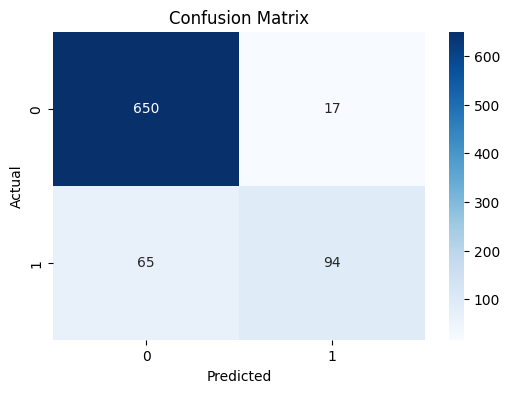

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### 3.6 Save best model + feature columns locally

In [ ]:
import joblib

joblib.dump(best_model, "model.joblib")
joblib.dump(list(X_train.columns), "feature_columns.joblib")

print("Saved: model.joblib, feature_columns.joblib")

Saved: model.joblib, feature_columns.joblib


### 3.7 Register best model in Hugging Face Model Hub

**Step A : Create a HF Model repo**
- Go to **Models → New model**
- Create a public repo named: `elegance567/visit-with-us-wellness-model`

**Step B: Upload model artifacts from this notebook**
Uploads:
- `model.joblib`
- `feature_columns.joblib`




---

## ✅ Criteria 4 — Model Deployment

This section satisfies all deployment requirements from the rubric.

### 1️⃣ Docker Configuration

The Space is deployed using **Docker + Streamlit template**.

The Dockerfile used in the Hugging Face Space:

```dockerfile
FROM python:3.10-slim

WORKDIR /app
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

COPY src/ ./src/

EXPOSE 7860
CMD ["streamlit", "run", "src/streamlit_app.py", "--server.port=7860", "--server.address=0.0.0.0"]
```

---

### 2️⃣ Dependencies File

The following dependencies are defined in `requirements.txt`:

```
streamlit
pandas
scikit-learn
joblib
huggingface_hub
```

---

### 3️⃣ Model Loading from Hugging Face Model Hub

The deployed app loads the saved model from:

```
elegance567/visit-with-us-wellness-model
```

Model artifacts:
- `model.joblib`
- `feature_columns.joblib`

---

### 4️⃣ Input Handling & DataFrame Creation

The Streamlit app:

- Collects user inputs
- Saves them into a Pandas DataFrame
- Applies one-hot encoding
- Aligns features to training columns
- Performs prediction

---

### 5️⃣ Hosting & Deployment

The Streamlit app is deployed on Hugging Face Spaces.

🔗 **Hugging Face Space Link:**  
https://huggingface.co/spaces/elegance567/visit-with-us-wellness-app

The Space builds automatically using Docker and runs the Streamlit app successfully.

---
